# Decision Trees

There are algorithms that fall into a class known as tree-based methods. The foundation for this class is the decision tree.

## What we will accomplish

In this notebook we will:
- Introduce decision trees,
- Define Gini Impurity and
- Review the CART algorithm used to fit a decision tree.

In [2]:
## For data handling
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns

## This sets the plot style
## to have a grid on a white background
sns.set_style("whitegrid")

## The basic idea

The basic idea for decision trees is to segment the data space in a way that allows us to classify well.

### A simple example

Let's look at a simple example. Below we generate some random data with an $x_1$ feature, an $x_2$ feature, and a target, $y$. We then plot the data. 

In [21]:
np.random.seed(334)
X = np.zeros((200,2))
X[:,0] = np.random.random(200)
X[100:,0] = X[100:,0] + 1.01
X[:100,0] = X[:100,0] - .01
X[:,1] = np.random.random(200)


y = np.zeros(200) 
y[100:] = 1
diff = np.random.randint(0,200,size = 10)
y[diff] = 1 - y[diff]

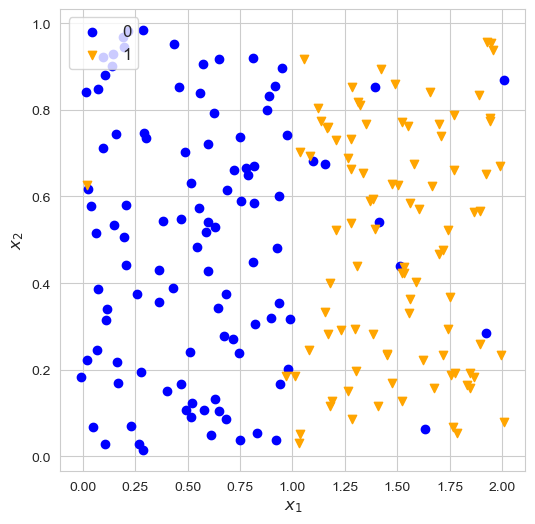

In [22]:
plt.figure(figsize = (6,6))
plt.scatter(X[y == 0,0], X[y == 0,1], c='blue', label="0")
plt.scatter(X[y == 1,0], X[y == 1,1], c='orange', marker="v", label="1")
plt.xlabel("$x_1$",fontsize = 12)
plt.ylabel("$x_2$",fontsize = 12)
plt.legend(fontsize=12, loc=2)

plt.show()

If you had to come up with an adhoc classification rule right now what would you say we should do?

<br>
<br>

One good choice would be to say that if the data point is to the left of $x_1= 1$ then we classify it as $0$, and if it to the right of $x_1=1$ then we classify it as $1$. We can illustrate this with a logic tree:
<img src = "lecture_10_assets/SimpleTree.png" width = "50%"></img>

While this is a simple example, it is the basic idea behind a decision tree. You look at a feature, choose a cut point that minimizes some measure of wrongness, and keep going until some stopping criterion.

Before we move on to real data, let's fit a decision tree to our dumb data and see what classification rule it comes up with. `sklearn` fits a decision tree with the model object, `DecisionTreeClassifier` <a href="https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html">https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html</a>.

In [5]:
## Import packages
## tree will be used to plot the decisiton tree
from sklearn import tree

## This is the actual out of the box algorithm
from sklearn.tree import 

SyntaxError: invalid syntax (2110270007.py, line 6)

In [ ]:
## Make a decision tree object
tree_clf =    # Use max_depth = 1

## fit the classifier


In [ ]:
## Plot the fitted tree
plt.figure(figsize = (5,5))
tree.plot_tree(tree_clf, filled = True)
plt.show()

In [ ]:
tree_clf.predict([[0.1,2],[1.9,-1]])

The plot above is the logic tree built by the decision tree algorithm. To classify a new observation we start at the <i>root node</i> up top. If the observation satisfies the logic statement at the top we go left and are classified as a $0$, else we go right and are classified as $1$. The two <i>children</i> of the root node are known as <i>leaf nodes</i> or <i>terminal nodes</i> because they have no children of their own so we just predict the majority class contained in that node.

This is essentially the decision rule we came up with (which is the objectively correct one by the way), so in this example the decision tree did well.


If we look in the plot above we notice a number of different stats in each node:

- `samples`: the number of samples in each node
- `gini`: the gini impurity of the node, more on this in a moment
- `value`: the breakdown of the number of samples of each target value in the node, for example the leaf node on the left has $100$ nodes labeled $0$ and $0$ nodes labeled $1$
- A decision rule: The rule that is used for the following split, samples that would be evaluated as True for the rule go to the left child, samples that would be evaluated as False go to the right child

### How is wrongness measured?

There are a couple of ways to measure wrongness, or rather impurity, with decision trees. There are two popular measures that can implemented with out of the box `sklearn`.

#### Gini impurity

Suppose that there are $N$ target classes.

The Gini Impurity for class $i$ of a node estimates the probability that a randomly chosen sample of class $i$ from the node is incorrectly classified as not class $i$. The formula is:
$$
G_i = p_i(1-p_i),
$$

where $p_i$ is the proportion of samples in the node of class $i$. The total Gini Impurity is the sum of all these $G_i$:

$$
I_G = \sum_{i=1}^N G_i = 1 - \sum_{i=1}^N p_i^2.
$$


#### Categorical Cross-Entropy

Categorical cross-entropy is an alternative impurity measure you could use when building a decision tree in `sklearn`. 

We have already discussed this metric in the `Multiclass Classification Metrics` notebook.

Again suppose there are $N$ target classes. The contribution made to entropy from class $i$ is:

$$
H_i = - p_i \log(p_i),
$$

where again $p_i$ is the proportion of samples in the node of class $i$. The total entropy of the node is the sum of all the $H_i$:

$$
I_H = \sum_{i=1}^N H_i = -\sum_{i=1}^N p_i \log(p_i).
$$

#### Which to use?

Note that the second order Taylor expansion of $-p\log(p)$ about $p = 1$ is $p(1-p)$.  So Gini Impurity can be seen as an approximation of categorical cross-entropy.  In practice using one or the other does not seem to impact model performance.  Computing logarithms adds a bit of computational complexity compared to squaring, so the Gini impurity could lead to a slight training time advantage.  

To get some intuition about "how close" these are, consider the 2 class case at a node with class fractions $p$ and $1-p$.  The Gini impurity is $2p(1-p)$ and the cross entropy is $-p\log(p)+(1-p)\log(1-p)$.

Plotting both functions on the interval $[0,1]$ (rescaling each to the value $1$ at $p=0.5$) shows not much difference between the two. 

In [ ]:
xs = np.linspace(0.0001,0.9999,1000)
plt.plot(xs, 4*xs*(1-xs), label = 'Gini')
plt.plot(xs, (-xs*np.log(xs) - (1-xs)*np.log(1-xs))/np.log(2), label = 'Entropy')
plt.legend()
plt.show()

## How `sklearn` fits a tree


### The CART algorithm

`sklearn` uses the <i>Classification and Regression Tree</i> or <i>CART</i> algorithm. 

Suppose your data set has $n$ observations with $m$ features, and for simplicity only $2$ target classes.

The algorithm starts with the root node. It then searches through each feature, $k$, and finds a split point, $t_k$, that produces the purest subsets (weighted by the number of samples in each subset), i.e. it finds a $t_k$ that minimizes:
$$
J(k,t_k) = \frac{n_\text{left}}{n} I_\text{left} + \frac{n_\text{right}}{n} I_\text{right},
$$
where left and right refers to being left or right of the split point, $t_k$, and $I$ is the impurity measure you choose to use (the default is Gini). 

Once it finds the $(k,t_k)$ pair that has smallest $J(k,t_k)$, it splits the data according to that decision split.

The algorithm then repeats the entire process on each of the children nodes it just produced. This continues until some stopping condition for example:
- reaching a maximum depth, controlled with `max_depth`
- reaching a minimum number of samples in each node, controlled with `min_samples_leaf`
- reaching a minimum weight to be in a node, controlled with `min_weight_fraction_leaf`
- etc., see documentation for further options, <a href="https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html">https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html</a>.

or until it can no longer reduce the impurity by making a cut.


We will end by demonstrating the effect of `max_depth` on a new randomly generated data set.

In [ ]:
np.random.seed(334)

n_samples = 300
X = np.random.uniform(low = -2, high = 2, size=(n_samples,2))

y = np.zeros(n_samples)
y[((X[:,0]-1)**2 +X[:,1]**2 > 1) & (X[:,0]**2 + X[:,1]**2 < 4)] = 1
y[((X[:,0]-1)**2 +X[:,1]**2 < 1)] = 2

In [ ]:
plt.figure(figsize = (10,10))

plt.scatter(X[y == 0,0], X[y == 0,1], c = 'red', marker = 'x', label = "0")
plt.scatter(X[y == 1,0], X[y == 1,1], c = 'orange', marker = 'v',label = "1")
plt.scatter(X[y == 2,0], X[y == 2,1], c = 'blue', label = "2")
plt.gca().add_patch(plt.Circle((1, 0), 1, color = 'k', fill = False))
plt.gca().add_patch(plt.Circle((0, 0), 2, color = 'k', fill = False))


plt.xlabel("$x_1$",fontsize = 12)
plt.ylabel("$x_2$",fontsize = 12)
plt.legend(fontsize=12, loc=2)

plt.show()

In [ ]:
from tree_helpers import SkNode, traversable_nodes

In [ ]:
from sklearn.metrics import accuracy_score
import matplotlib.patches as patches

s = 50

for i in range(1,11):
    tree_clf = DecisionTreeClassifier(max_depth  = i, random_state = 216)
    
    tree_clf.fit(X, y)
    
    accuracy = accuracy_score(y, tree_clf.predict(X))

    plt.figure(figsize=(8,8))
    

    nodes = traversable_nodes(tree_clf)

    for node in nodes.values():
        if node.leaf:
            (xmin,ymin),(xmax,ymax) = node.find_constraints()
            xmin = np.max([xmin,-2])
            xmax = np.min([xmax,2])
            ymin = np.max([ymin,-2])
            ymax = np.min([ymax,2])
            def add_patch(face_color):
                plt.gca().add_patch(
                    patches.Rectangle(
                        (xmin, ymin), xmax-xmin, ymax-ymin, linewidth=2, edgecolor='k', facecolor = face_color, zorder = -2, alpha = 0.4)
                    )
            if node.pred == 0:
                add_patch('red')
            elif node.pred == 1:
                add_patch('orange')
            elif node.pred == 2:
                add_patch('blue')

    plt.scatter(X[y == 0,0], X[y == 0,1], c = 'red', marker = 'x', label = "0")
    plt.scatter(X[y == 1,0], X[y == 1,1], edgecolors= 'k', c = 'orange', marker = 'v',label = "1",alpha=1)
    plt.scatter(X[y == 2,0], X[y == 2,1], edgecolors= 'k', c = 'blue', label = "2")
    plt.gca().add_patch(plt.Circle((1, 0), 1, color = 'k', fill = False))
    plt.gca().add_patch(plt.Circle((0, 0), 2, color = 'k', fill = False))

    plt.title(f"Maximum Depth of {i} \n Accuracy = {accuracy:.4f}", fontsize=14)
    plt.xlabel("$x_1$", fontsize=12)
    plt.ylabel("$x_2$", fontsize=12)
    plt.legend(fontsize=12)

    plt.show()


Note that the CART algorithm is deterministic aside from edge cases where two different cuts would make equal reductions in the weighted Gini impurity. The only randomness in the algorithm is deciding which of these edge case cuts to choose.  We set `random_state = 216` for reproducibility and to make sure that the latter trees are refinements of the former.

Typically for the "best" choice of `max_depth` we would run something like cross-validation.

Before we close the jupyter notebook on decision trees let's leave with a few take aways.


##### Advantages

- Interpret-ability :
    - Decision Trees are known as a white box algorithm (as opposed to the black box often used to describe machine learning). This is because you are able to entirely describe how a decision tree predicts a data points target using the logic tree,
- Very Fast Predictions and
- Very little preprocessing of data prior to training.

##### Disadvantages

- Greediness:
    - The algorithm is greedy meaning it may not create the optimal tree. For example, maybe the best tree involves an initial suboptimal cut, the CART algorithm won't find this tree.
- Overfitting: 
    - Decision trees are very prone to overfitting the data, you can control for this using regularization hyperparameters like max_depth and min_samples_split. It's also a good idea to use cv when you can.
- Orthogonal Boundaries:
    - Because of the process of determining cut points (remember the $t_k$ from the algorithm?) decision boundaries happen at right angles. This means that classes divided by a non-horizontal or non-vertical line the decision tree will have some capturing the boundary. This can be mitigated a bit with PCA.
- Sensitive:
    - Trees are very sensitive to the training data. Removing or adding a few points can greatly change the decision boundary produced by the algorithm. One way around this is to use an averaged algorithm, like a random forest. We discuss these in a later notebook.

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2023.  Modified by Steven Gubkin 2024.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)